In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import sys
sys.path.append("/kaggle/input/omc-dataset/")

In [4]:
import pandas as pd
import glob
import os

base_dir = "/kaggle/input/omc-dataset/per_cell_grouped_output/"

csv_files = glob.glob(os.path.join(base_dir, "group_*.csv"))
csv_files = csv_files[:30]
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {base_dir} with pattern 'group_*.csv'")
print(f"Building the dataset")
df = pd.concat([pd.read_csv(f,sep=",",low_memory=False) for f in csv_files], ignore_index=True)
df.columns = df.columns.str.strip()
df["Time"] = pd.to_datetime(df["Time"], errors='coerce')


Building the dataset


In [5]:
df.head()

,Time,eNodeB Name,Cell FDD TDD Indication,Cell Name,LocalCell Id,eNodeB Function Name,Integrity,L.Cell.Avail.Dur(s),L.CSFB.PrepAtt,L.CSFB.PrepSucc,...,L.RRC.ConnReq.Succ.MoSig,L.RRC.ConnReq.Succ.Mt,L.RRC.ReEst.Att,L.RRC.ReEstFail.Rej,L.Thrp.bits.DL(bit),L.Thrp.bits.UL(bit),L.Thrp.Time.Cell.DL.HighPrecision(ms),L.Thrp.Time.Cell.UL.HighPrecision(ms),L.S1Sig.ConnEst.Succ,L.S1Sig.ConnEst.Att
0,2025-06-01,DIAMEGUENE02_REMP_R_L,CELL_FDD,DIAMEGUENE02_REMP_e10_a,30.0,DIAMEGUENE02_REMP_L,100%,3600.0,167.0,167.0,...,891.0,2916.0,53.0,9.0,1.040334e+11,1.501498e+10,3187699.0,1674184.0,8952.0,8952.0
1,2025-06-01,DIAMEGUENE02_REMP_R_L,CELL_FDD,DIAMEGUENE02_REMP_e10_a,30.0,DIAMEGUENE02_REMP_L,100%,3600.0,167.0,167.0,...,891.0,2916.0,53.0,9.0,1.040334e+11,1.501498e+10,3187699.0,1674184.0,8952.0,8952.0
2,2025-06-01,DIAMEGUENE02_REMP_R_L,CELL_FDD,DIAMEGUENE02_REMP_e10_a,30.0,DIAMEGUENE02_REMP_L,100%,3600.0,167.0,167.0,...,891.0,2916.0,53.0,9.0,1.040334e+11,1.501498e+10,3187699.0,1674184.0,8952.0,8952.0
3,2025-06-01,DIAMEGUENE02_REMP_R_L,CELL_FDD,DIAMEGUENE02_REMP_e10_a,30.0,DIAMEGUENE02_REMP_L,100%,3600.0,167.0,167.0,...,891.0,2916.0,53.0,9.0,1.040334e+11,1.501498e+10,3187699.0,1674184.0,8952.0,8952.0
4,2025-06-01,DIAMEGUENE02_REMP_R_L,CELL_FDD,DIAMEGUENE02_REMP_e10_a,30.0,DIAMEGUENE02_REMP_L,100%,3600.0,167.0,167.0,...,891.0,2916.0,53.0,9.0,1.040334e+11,1.501498e+10,3187699.0,1674184.0,8952.0,8952.0


In [6]:
target_col = "L.Thrp.bits.UL(bit)"
features_cols = [
    "L.Thrp.bits.DL(bit)",
    "L.E-RAB.AttEst",
    "L.E-RAB.SuccEst",
    "L.S1Sig.ConnEst.Att",
    "L.S1Sig.ConnEst.Succ",
    target_col
]

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


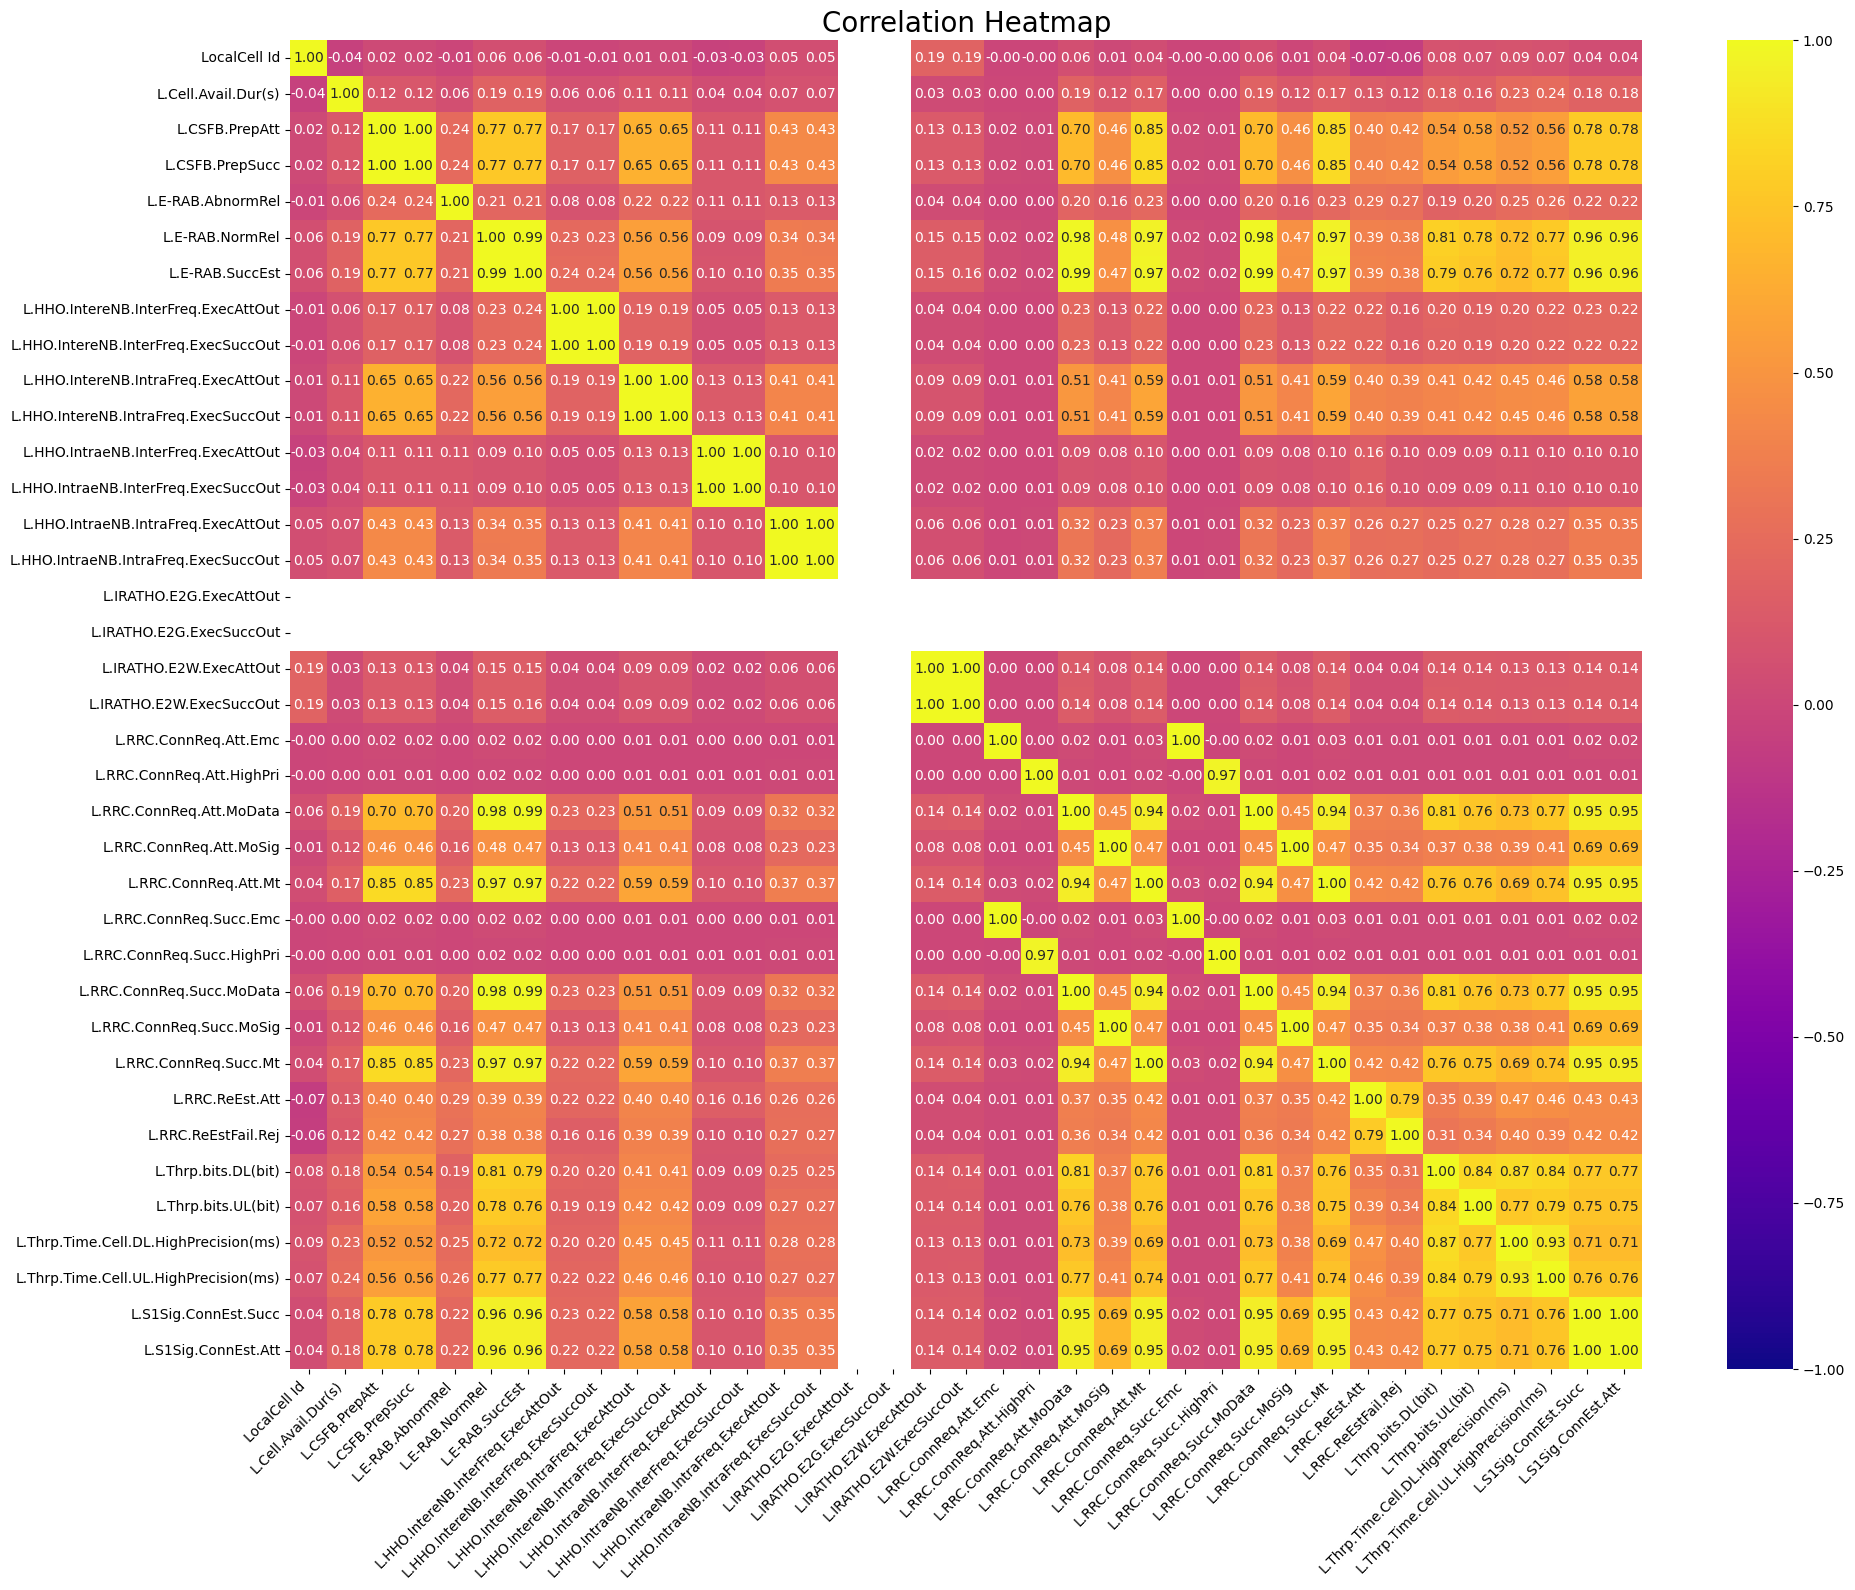

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='plasma',vmin=-1,vmax=1,fmt=".2f",square=False) 
plt.title("Correlation Heatmap", fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

In [8]:
# Convert all numeric columns to float
for col in df.columns:
    if col not in ['Time', 'eNodeB Name', 'Cell Name', 'eNodeB Function Name', 'Cell FDD TDD Indication']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [9]:
from sklearn.preprocessing import MinMaxScaler

df = df.dropna(subset=features_cols + ["Cell Name", "Time"])
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(df[features_cols])
scaler_y.fit(df[[target_col]])

MinMaxScaler()

In [10]:
cell_names = df["Cell Name"].unique().tolist()
cell_to_id = {name: idx for idx, name in enumerate(cell_names)}

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [12]:
%%time
seq_len = 50
all_seq = []
df["Time"] = pd.to_datetime(df["Time"])
unique_times = sorted(df["Time"].dropna().unique())
time_to_id = {t: i for i, t in enumerate(unique_times)}

CPU times: user 146 ms, sys: 42 ms, total: 188 ms
Wall time: 190 ms


In [13]:
print(df["Time"].info())

<class 'pandas.core.series.Series'>
Index: 5344734 entries, 0 to 5344801
Series name: Time
Non-Null Count    Dtype         
--------------    -----         
5344734 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 81.6 MB
None


In [14]:
import numpy as np

In [15]:
%%time
all_seq = []
for cell in cell_names[:1000]:
    cell_df = df[df["Cell Name"] == cell]
    cell_df = cell_df[["Time"] + features_cols].dropna()
    features = scaler_x.transform(cell_df[features_cols].values)
    target   = scaler_y.transform(cell_df[[target_col]]).flatten()
    dates = pd.to_datetime(cell_df["Time"].values)  # convert to pd.Timestamp

    for i in range(len(features) - seq_len):
        x = features[i:i+seq_len]
        y = target[i + seq_len]
        time_ids = [time_to_id[date] for date in dates[i:i+ seq_len]]
        cell_id = cell_to_id[cell]
        time_ids = np.array(time_ids).reshape(-1, 1)
        x_with_time = np.concatenate([x, time_ids], axis=1)
        all_seq.append((x_with_time,cell_id,y))

CPU times: user 7min 18s, sys: 2.4 s, total: 7min 21s
Wall time: 7min 21s


In [17]:
device = "cuda"

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X_list = []
y_list = []

for x_with_time, cell_id, y in all_seq:
    agg_features = []
    for col in range(x_with_time.shape[1]):
        col_vals = x_with_time[:, col]
        agg_features.extend([
            col_vals.mean(),
            col_vals.std(),
            col_vals.min(),
            col_vals.max(),
            col_vals[-1]
        ])
    # Append cell_id
    agg_features.append(cell_id)
    
    X_list.append(agg_features)
    y_list.append(y)

X = np.array(X_list)
y = np.array(y_list)

print(f"Aggregated X shape: {X.shape}, y shape: {y.shape}")


Aggregated X shape: (1720964, 36), y shape: (1720964,)


RMSE: 0.0053
R²: 0.9724


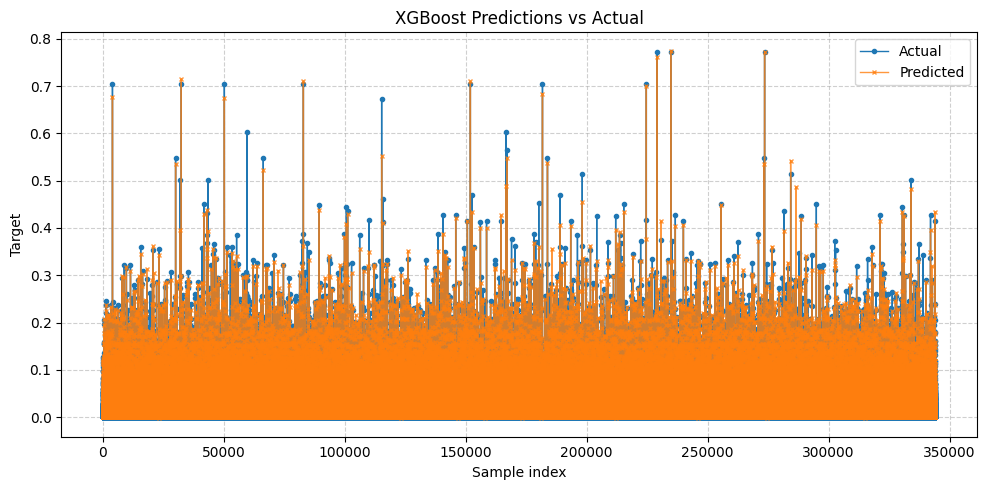

In [19]:
# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Train GPU XGBoost
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    random_state=42
)
model.fit(X_train, y_train)

# 4. Predict & evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# 5. Plot Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual", marker='o', markersize=3, linewidth=1)
plt.plot(y_pred, label="Predicted", marker='x', markersize=3, linewidth=1, alpha=0.8)
plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Sample index")
plt.ylabel("Target")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

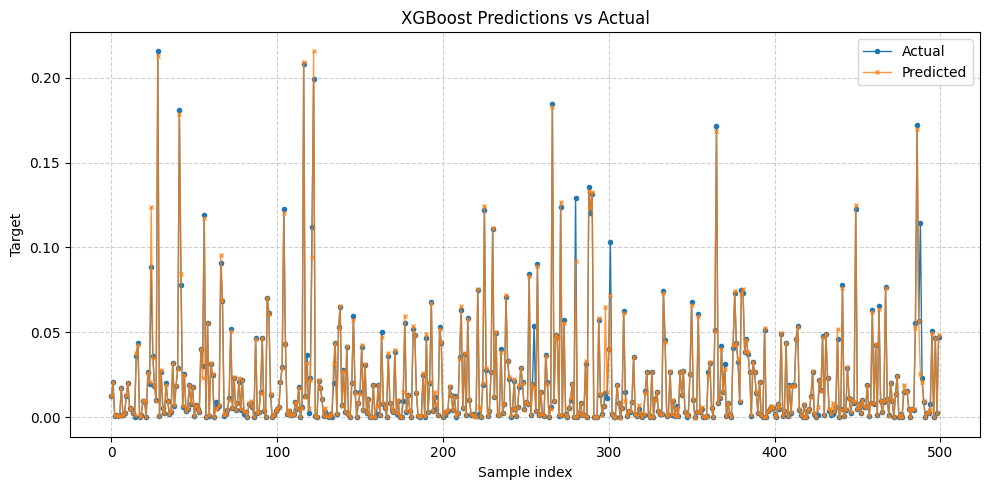

In [20]:
plt.figure(figsize=(10,5))
plt.plot(y_test[2000:2500], label="Actual", marker='o', markersize=3, linewidth=1)
plt.plot(y_pred[2000:2500], label="Predicted", marker='x', markersize=3, linewidth=1, alpha=0.8)
plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Sample index")
plt.ylabel("Target")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

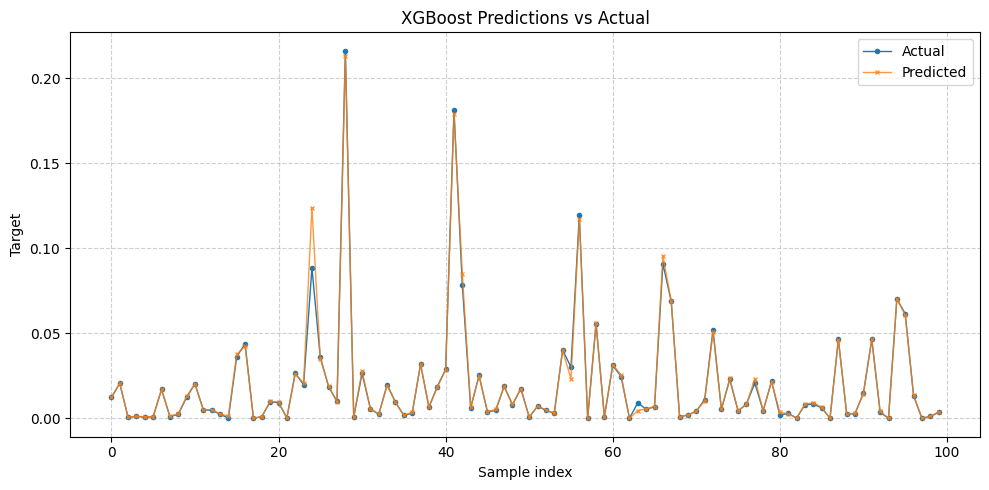

In [21]:
plt.figure(figsize=(10,5))
plt.plot(y_test[2000:2100], label="Actual", marker='o', markersize=3, linewidth=1)
plt.plot(y_pred[2000:2100], label="Predicted", marker='x', markersize=3, linewidth=1, alpha=0.8)
plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Sample index")
plt.ylabel("Target")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()